# 0. 환경설정

In [1]:
import os
import glob
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Activation, Flatten, GlobalAveragePooling2D
from sklearn.metrics import classification_report


import time
from tensorflow.python.client import device_lib

In [2]:
import os
os.getcwd()

'C:\\Users\\bigcompetmgr019'

In [3]:
os.chdir('F:\Competition_No1\code')

In [4]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5974974743042415549
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15957406516
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2494654222135816827
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


# 1. Load Data

In [5]:
train_dir = "F://Competition_No1/datasets/train"

Empty_train = glob.glob(os.path.join(train_dir, '0/*.png'))
Load_train = glob.glob(os.path.join(train_dir, '1/*.png'))

In [6]:
test_dir = "F://Competition_No1/datasets/test"

Empty_test = glob.glob(os.path.join(test_dir, '0/*.jpg'))
Load_test = glob.glob(os.path.join(test_dir, '1/*.jpg'))

In [7]:
# png_image to numpy_array

In [8]:
Empty_img = np.array(list(map(lambda x: (img_to_array(load_img(Empty_train[x]), dtype=np.uint8)), range(len(Empty_train)))))
Load_img = np.array(list(map(lambda x: (img_to_array(load_img(Load_train[x]), dtype=np.uint8)),range(len(Load_train)))))

In [9]:
print(Empty_img.shape)
print(Load_img.shape)

(7748, 492, 654, 3)
(4623, 492, 654, 3)


# 2. Preview Data 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


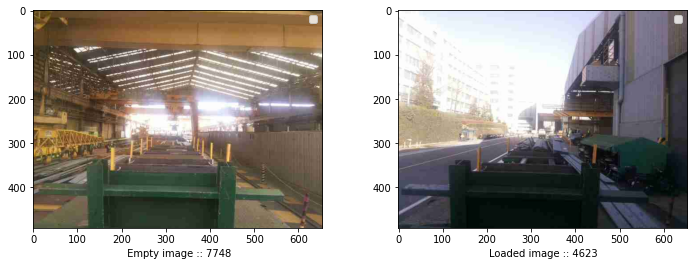

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel(f' Empty image :: {len(Empty_train)}')
plt.imshow(Empty_img[0,:,:,:])
plt.legend()

plt.subplot(1,2,2)
plt.xlabel(f'Loaded image :: {len(Load_train)}')
plt.imshow(Load_img[0,:,:,:])
plt.legend()

# 3. Image Augmentation

In [11]:
ih = Load_img.shape[1]
iw = Load_img.shape[2]
print(ih, iw)

492 654


In [12]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.2, #사진 찌그러 뜨리기
    width_shift_range=2,
    height_shift_range=2,
    horizontal_flip=True,
    vertical_flip=False,  #사진이 위아래로 뒤집힐 일은 없을 듯
    fill_mode='nearest',#어차피 화물은 중앙 근처에 있으니 nearest로 함
    brightness_range=[0.3,1.0],
    validation_split = 0.1,
    rescale=1/255.
)

valid_gen = ImageDataGenerator(
    validation_split = 0.1,
    rescale=1/255.
)


### 3-1 Augment 확인

In [13]:
#np.tile(A,reps) Af를 reps만큼 반복
#imageDataGenerator.flow(이미지,이미지라벨,batch_size)

In [14]:
augment_size = 30
Empty_augment = train_gen.flow(np.tile(Empty_img[150].reshape(492*654*3), augment_size).reshape(-1,492,654,3),
                              np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

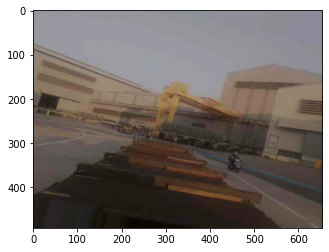

In [15]:
plt.imshow(Empty_augment[0])

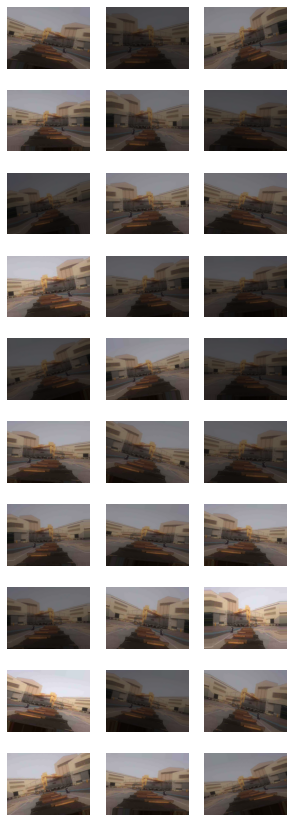

In [16]:
plt.figure(figsize=(5,15))
for i in range(1, 31):
    plt.subplot(10, 3, i)
    plt.axis('off')
    plt.imshow(Empty_augment[i-1], cmap='gray')

### 3-2 Load augment data 만들고 dir에 저장

In [17]:
augment_size2 = 3000

random_mask2 = np.random.randint(Load_img.shape[0], size=augment_size2)
Load_augment = Load_img[random_mask2].copy()

In [18]:
Load_augment.shape

In [22]:
Load_augmented = train_gen.flow(Load_augment.reshape(-1,492,654,3),
                             np.zeros(augment_size2), batch_size=augment_size2, shuffle=False).next()[0]

In [23]:
for i in range(3000):
    im = Image.fromarray((Load_augmented[i]*255).astype(np.uint8))
    im.save("F://Competition_No1/datasets/new_train/new_1/{0}.png".format(i))

# 4. generator 생성

In [24]:
train_generator = train_gen.flow_from_directory(directory='F://Competition_No1/datasets/new_train/', #이미지가 분류되어있는 디렉토리
                                               target_size=(224,224), #이미지들을 244x244로 resizing
                                               classes=['new_0','new_1'],
                                               class_mode='categorical', #output 클래스 형태
                                               batch_size=32, #미니배치 사이즈
                                               shuffle=True,
                                               subset='training')

valid_generator = valid_gen.flow_from_directory(directory='F://Competition_No1/datasets/new_train/',
                                               target_size=(224,224),
                                               classes=['new_0','new_1'],
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               subset='validation')

Found 13835 images belonging to 2 classes.
Found 1536 images belonging to 2 classes.


In [25]:
#label의 클래스 확인
print(train_generator.class_indices)
print(valid_generator.class_indices)

#step수 (1epoch 당 몇번 weight를 업데이트를 할 것인지)
len(train_generator), len(valid_generator)


{'new_0': 0, 'new_1': 1}
{'new_0': 0, 'new_1': 1}


(433, 48)

# 5. 모델 생성 (ResNet50)

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [27]:
pretrained_model = ResNet50(input_shape=(224,224,3),include_top=False, weights=None)
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [28]:
def create_model(verbose=False):
    input_tensor = Input(shape=(224,224,3))
    pretrained_model = ResNet50(input_tensor=input_tensor, include_top=False, weights='imagenet')
    pretrained_model.trainanble = False
    pretrained_output = pretrained_model.output
    
    #Customize Classifier layer
    x = GlobalAveragePooling2D()(pretrained_output)
    x = Dense(128,activation='relu')(x)
    output = Dense(units=2, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()
    return model

model = create_model(verbose=False)

#모델 컴파일
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# 6. 모델 1차 학습

In [30]:
#모델 학습

history = model.fit_generator(
    train_generator, 
    validation_data = valid_generator,
    epochs=20,
    callbacks=[ ModelCheckpoint('model_dw.h5',monitor='val_accuracy',save_best_only=True,verbose=1),
              EarlyStopping(patience=5)] )



  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 433 steps, validate for 48 steps
Epoch 1/20
432/433 [============================>.] - ETA: 1s - loss: 0.1612 - accuracy: 0.9352
Epoch 00001: val_accuracy improved from -inf to 0.52214, saving model to model_dw.h5
433/433 [==============================] - 496s 1s/step - loss: 0.1608 - accuracy: 0.9353 - val_loss: 0.8359 - val_accuracy: 0.5221
Epoch 2/20
432/433 [============================>.] - ETA: 0s - loss: 0.0824 - accuracy: 0.9696
Epoch 00002: val_accuracy improved from 0.52214 to 0.75391, saving model to model_dw.h5
433/433 [==============================] - 234s 540ms/step - loss: 0.0826 - accuracy: 0.9696 - val_loss: 0.5915 - val_accuracy: 0.7539
Epoch 3/20
432/433 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9778
Epoch 00003: val_accuracy improved from 0.75391 to 0.80469, saving model to model_dw.h5
433/433 [==============================] - 207s 477ms/step - loss: 0.0590 - accuracy: 0.977

### 6-1 1차 평가

In [31]:
#모델 평가
test0 = np.array(list(map(lambda x: (img_to_array(load_img(Empty_test[x]).resize((224, 224)), dtype=np.uint8)), range(len(Empty_test)))))/255.
test1 = np.array(list(map(lambda x: (img_to_array(load_img(Load_test[x]).resize((224, 224)), dtype=np.uint8)), range(len(Load_test)))))/255.

In [37]:
model = load_model('model_dw.h5')
start = time.time()
pred1 = model.predict(test0)
end = time.time()
seconds = end-start
print("Time taken : {0}".format(seconds))
#pred1 = np.argmax(pred1,axis=1)
pred1

Time taken : 0.8700408935546875


array([[0.06707815, 0.9329219 ],
       [0.30058426, 0.69941574],
       [0.9838891 , 0.01611089],
       [0.7484548 , 0.25154522],
       [0.79599506, 0.20400499],
       [0.4062871 , 0.59371287],
       [0.43077213, 0.5692279 ],
       [0.5842803 , 0.41571972],
       [0.4954095 , 0.5045905 ],
       [0.9495435 , 0.0504565 ]], dtype=float32)

In [35]:
np.argmax(pred1,axis=1)

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 0], dtype=int64)

In [36]:
pred2 = model.predict(test1)
pred2 = np.argmax(pred2,axis=1)
pred2

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

# 7. Fine-Tuning (모델 재학습)

In [39]:
len(model.layers)

178

In [53]:
for layer in model.layers[:-7]:
    layer.trainable = False
for layer in model.layers[-7:]:
    layer.trainable = True

In [59]:
from tensorflow.keras.optimizers import SGD

model.compile(loss="binary_crossentropy",
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=["accuracy"])

In [60]:
history = model.fit_generator(
    train_generator, 
    validation_data = valid_generator,
    epochs=20,
    callbacks=[ ModelCheckpoint('model_dw2.h5',monitor='val_accuracy',save_best_only=True,verbose=1),
              EarlyStopping(patience=5)] )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 433 steps, validate for 48 steps
Epoch 1/20
432/433 [============================>.] - ETA: 0s - loss: 0.0257 - accuracy: 0.9905
Epoch 00001: val_accuracy improved from -inf to 0.91667, saving model to model_dw2.h5
433/433 [==============================] - 209s 482ms/step - loss: 0.0256 - accuracy: 0.9905 - val_loss: 0.1964 - val_accuracy: 0.9167
Epoch 2/20
432/433 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9896
Epoch 00002: val_accuracy improved from 0.91667 to 0.92057, saving model to model_dw2.h5
433/433 [==============================] - 205s 473ms/step - loss: 0.0289 - accuracy: 0.9897 - val_loss: 0.1871 - val_accuracy: 0.9206
Epoch 3/20
432/433 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9915
Epoch 00003: val_accuracy improved from 0.92057 to 0.92513, saving model to model_dw2.h5
433/433 [==============================] - 205s 474ms/step - loss: 0.0273 - accuracy:

# 8. 최종모델 load & 성능테스트

### 8-1 inference speed 

In [152]:
model = load_model('model_dw2.h5')
start = time.time()
pred1 = model.predict(test0)
pred2 = model.predict(test1)
end = time.time()
seconds = end-start
print("Time taken : {0}".format(seconds))
fps = round(seconds/(len(test0)+len(test1)),3)*1000
print(str(fps)+'ms')

Time taken : 0.9580109119415283
48.0ms


In [153]:
np.argmax(pred1,axis=1)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [154]:
np.argmax(pred2,axis=1)

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

### 8-2 test accuracy

In [155]:
test_gen = ImageDataGenerator(rescale=1/255.)

In [156]:
test_generator = test_gen.flow_from_directory(directory='F://Competition_No1/datasets/test/',
                                               target_size=(224,224),
                                               classes=['0','1'],
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True)

Found 20 images belonging to 2 classes.


In [157]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

  ...
    to  
  ['...']
1/1 [==============================] - 1s 1s/step - loss: 0.9725 - accuracy: 0.8000
Test accuracy : 0.8


Predictions:
 [0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0]
Labels:
 [[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


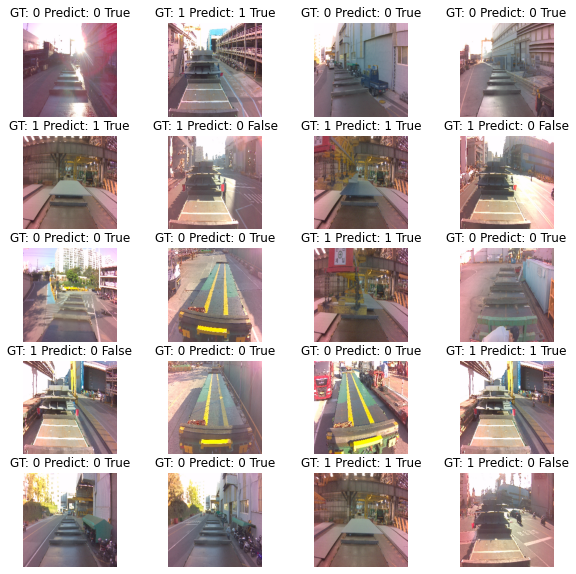

In [238]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_generator.next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = np.argmax(predictions,axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(20):
  GT = str(np.argmax(label_batch[i]))
  Predict = str(predictions[i])
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image_batch[i])
  if GT == Predict:
    plt.title('GT: '+GT+' Predict: '+Predict+' True') 
  else:
    plt.title('GT: '+GT+' Predict: '+Predict+' False') 
  plt.axis("off")

# 9. result.csv 구축

In [234]:
Image_list = []
Ground_Truth = []
Pred = []
acc =[]

for i in range(test_generator[0][0].shape[0]):
    Image_list.append('image {0}'.format(i))
    Ground_Truth.append(np.argmax(label_batch[i]))
    Pred.append(predictions[i])
    if np.argmax(label_batch[i])==predictions[i]:
        acc.append(True)
    else: 
        acc.append(False)

In [235]:
Average_acc = df['accuracy'].value_counts(True)[1]

In [236]:
import csv
f = open('result.csv','w',newline='')
wr = csv.writer(f)
for i in range(test_generator[0][0].shape[0]):
    wr.writerow([Image_list[i],Ground_Truth[i],Pred[i],acc[i]])
wr.writerow(['Average Accuracy',Average_acc])
wr.writerow(['Inference Speed(ms)',str(fps)+'ms/image'])
f.close()